In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn import metrics
import math
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import (StandardScaler, 
                                   PolynomialFeatures)

from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import xgboost
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


from sklearn.ensemble import GradientBoostingRegressor

# Importing and Initially exploring the data

In [2]:
df=pd.read_csv('../input/seoul-bike-rental-ai-pro-iti/train.csv')
df.head()

,ID,Date,y,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


# Adding Y_AVG_HOUR_SEASON FEATURE

In [3]:
Winter_df = df.loc[(df['Seasons'] == 'Winter')]
Summer_df = df.loc[(df['Seasons'] == 'Summer')]
Autumn_df = df.loc[(df['Seasons'] == 'Autumn')]
Spring_df = df.loc[(df['Seasons'] == 'Spring')]
################################

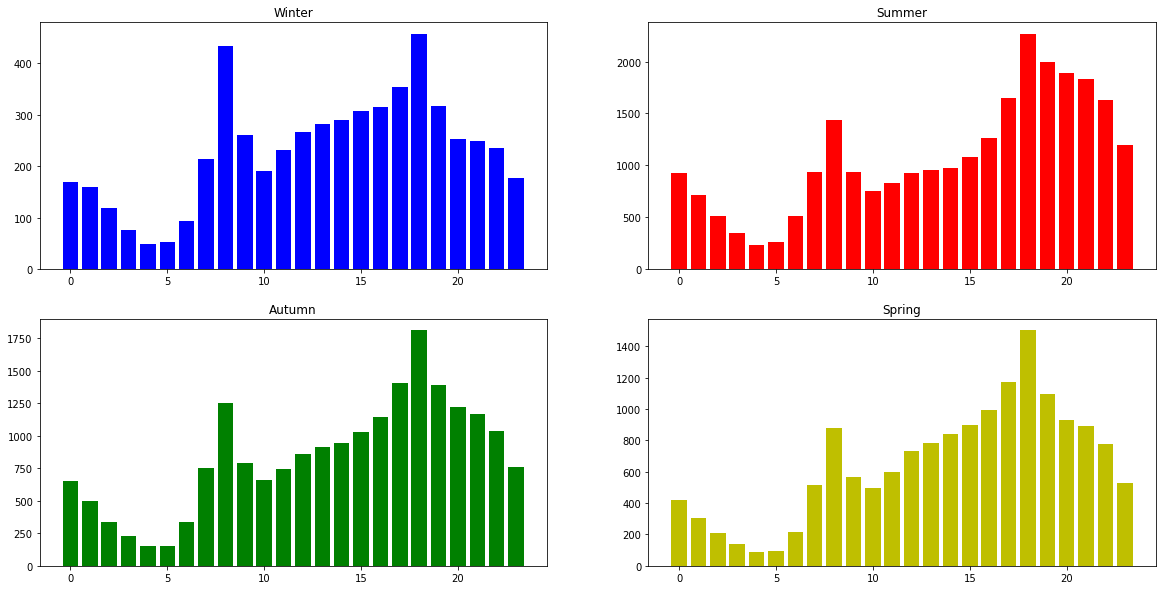

In [4]:
temp_winter = Winter_df.groupby('Hour').mean()
temp_summer = Summer_df.groupby('Hour').mean()
temp_autumn = Autumn_df.groupby('Hour').mean()
temp_spring = Spring_df.groupby('Hour').mean()
#################################################
y_Hour_winter = temp_winter['y']
y_Hour_summer = temp_summer['y']
y_Hour_autumn = temp_autumn['y']
y_Hour_spring = temp_spring['y']
Hour = np.arange(0,24,step = 1)
# ax = plt.subplots(2,2,1)
fig, axs = plt.subplots(2, 2,figsize=(20,10))
axs[0, 0].bar(Hour,y_Hour_winter,color = 'b')
axs[0, 0].set_title('Winter')
axs[0, 1].bar(Hour,y_Hour_summer,color = 'r')
axs[0, 1].set_title('Summer')
axs[1, 0].bar(Hour,y_Hour_autumn,color = 'g')
axs[1, 0].set_title('Autumn')
axs[1, 1].bar(Hour,y_Hour_spring,color='y')
axs[1, 1].set_title('Spring')
plt.show()


In [5]:
##############################################
y_Hour_autumn_df = pd.DataFrame(Hour,columns = ['Hour'])
y_Hour_autumn_df['Seasons'] = 'Autumn'
y_Hour_autumn_df['y_avg_autumn_hour'] = y_Hour_autumn

y_Hour_spring_df = pd.DataFrame(Hour,columns = ['Hour'])
y_Hour_spring_df['Seasons'] = 'Spring'
y_Hour_spring_df['y_avg_spring_hour'] = y_Hour_spring

y_Hour_summer_df = pd.DataFrame(Hour,columns = ['Hour'])
y_Hour_summer_df['Seasons'] = 'Summer'
y_Hour_summer_df['y_avg_summer_hour'] = y_Hour_summer

y_Hour_winter_df = pd.DataFrame(Hour,columns = ['Hour'])
y_Hour_winter_df['Seasons'] = 'Winter'
y_Hour_winter_df['y_avg_winter_hour'] = y_Hour_winter
#######################################################
merged_df=pd.merge(df,y_Hour_autumn_df,on=['Seasons','Hour'],how='left')
merged_df=pd.merge(merged_df,y_Hour_spring_df,on=['Seasons','Hour'],how='left')
merged_df=pd.merge(merged_df,y_Hour_summer_df,on=['Seasons','Hour'],how='left')
merged_df=pd.merge(merged_df,y_Hour_winter_df,on=['Seasons','Hour'],how='left')
########################################################
merged_df = merged_df.fillna(0)
##################################
merged_df['y_avg_season_hour'] = merged_df['y_avg_autumn_hour']+ merged_df['y_avg_spring_hour'] +merged_df['y_avg_summer_hour'] +merged_df['y_avg_winter_hour']
df['y_avg_season_hour'] = merged_df['y_avg_season_hour']

# Clustering Weather Data

In [6]:
cluster_list = ['Temperature(�C)','Humidity(%)','Wind speed (m/s)','Visibility (10m)','Solar Radiation (MJ/m2)','Rainfall(mm)','Snowfall (cm)']
X = StandardScaler().fit_transform(df[cluster_list])
kmeans = KMeans(n_clusters=14)
model = kmeans.fit(X)
df['weathercluster'] = model.predict(StandardScaler().fit_transform(df[cluster_list]))

In [7]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
ID,5760.0,2879.500000,1662.913107,0.000000,1439.750,2879.500000,4319.250,5759.000000
y,5760.0,703.483854,655.249491,0.000000,188.000,485.500000,1066.000,3556.000000
Hour,5760.0,11.500000,6.922788,0.000000,5.750,11.500000,17.250,23.000000
Temperature(�C),5760.0,12.803559,11.902206,-15.100000,3.200,13.700000,22.225,39.400000
Humidity(%),5760.0,58.361806,19.840167,0.000000,43.000,57.000000,73.000,98.000000
Wind speed (m/s),5760.0,1.723333,1.047898,0.000000,0.900,1.500000,2.300,7.400000
Visibility (10m),5760.0,1473.711458,585.879880,27.000000,1025.750,1732.000000,2000.000,2000.000000
Dew point temperature(�C),5760.0,4.058264,13.003582,-26.900000,-5.400,5.200000,14.700,27.200000
Solar Radiation (MJ/m2),5760.0,0.572325,0.869943,0.000000,0.000,0.010000,0.940,3.520000
Rainfall(mm),5760.0,0.135122,1.075320,0.000000,0.000,0.000000,0.000,35.000000


## Encoding non numeric catagorical data  

In [8]:
print(df['Functioning Day'].unique())
print(df['Seasons'].unique())
print(df['Holiday'].unique())

['Yes' 'No']
['Winter' 'Spring' 'Summer' 'Autumn']
['No Holiday' 'Holiday']


In [9]:
y=df[['y']]
X=df.drop(['y','ID'], axis=1)
y=np.ravel(y)


In [10]:
X1=X.copy()
from sklearn.preprocessing import LabelBinarizer
def Binarizer(column,data):
    encoder = LabelBinarizer()
    encoder.fit(data[column].astype(str))
    transformed = encoder.transform(data[column].astype(str))
    ohe_df = pd.DataFrame(transformed)
    data = pd.concat([data, ohe_df], axis=1).drop([column], axis=1)
    data=data.rename(columns={0:column})
    data[column]=data[column].astype(np.int64)
    return data
#X1=Binarizer('Holiday',X1)
X1=Binarizer('Functioning Day',X1)


In [11]:
# defining Lag features

features=['Hour','Temperature(�C)','Visibility (10m)','Solar Radiation (MJ/m2)','y_avg_season_hour'\
          ,'Humidity(%)','Wind speed (m/s)','Snowfall (cm)','Rainfall(mm)','Dew point temperature(�C)','weathercluster']

def lag(data,features, shift):
    for feature in features:
        data['lag_'+str(shift)+'_'+feature] = data[feature].shift(shift)

In [12]:


#Changing date object to datetime 
X1['Date']=pd.to_datetime(X1['Date'])
X1['year']=pd.to_datetime(X1['Date'].dt.year).astype(np.int64)
X1['day']=pd.to_datetime(X1['Date'].dt.day).astype(np.int64)

#creating DayOfWeek feature
X1['dayofweek'] = X1['Date'].dt.dayofweek
X1['WeekOfYear'] = X1['Date'].dt.isocalendar().week.astype(np.int64)
X1['DayofYear'] = X1['Date'].dt.dayofyear

X1['hours_dt'] = pd.to_datetime(X1['Hour'], format='%H')
hours_list = [7,8,9,17,18,19,20,21,22]
X1['Travelling_time'] = np.where(X1['Hour'].isin(hours_list), 1, 0)


lag(X1,features,-1)
lag(X1,features,-3)
lag(X1,features,-5)
lag(X1,features,-7)
lag(X1,features,-9)
lag(X1,features,-11)
lag(X1,features,3)
lag(X1,features,1)


X1.fillna(0,inplace=True)

In [13]:
X1.describe()


,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),y_avg_season_hour,...,lag_1_Temperature(�C),lag_1_Visibility (10m),lag_1_Solar Radiation (MJ/m2),lag_1_y_avg_season_hour,lag_1_Humidity(%),lag_1_Wind speed (m/s),lag_1_Snowfall (cm),lag_1_Rainfall(mm),lag_1_Dew point temperature(�C),lag_1_weathercluster
count,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,...,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000
mean,11.500000,12.803559,58.361806,1.723333,1473.711458,4.058264,0.572325,0.135122,0.046302,703.483854,...,12.801944,1473.397743,0.572325,703.351904,58.354340,1.722726,0.046302,0.135122,4.058715,6.671181
std,6.922788,11.902206,19.840167,1.047898,585.879880,13.003582,0.869943,1.075320,0.323728,502.743488,...,11.903312,586.185095,0.869943,502.828376,19.854033,1.047883,0.323728,1.075320,13.003396,4.178331
min,0.000000,-15.100000,0.000000,0.000000,27.000000,-26.900000,0.000000,0.000000,0.000000,49.333333,...,-15.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-26.900000,0.000000
25%,5.750000,3.200000,43.000000,0.900000,1025.750000,-5.400000,0.000000,0.000000,0.000000,260.175000,...,3.200000,1025.000000,0.000000,258.300000,43.000000,0.900000,0.000000,0.000000,-5.400000,4.000000
50%,11.500000,13.700000,57.000000,1.500000,1732.000000,5.200000,0.010000,0.000000,0.000000,653.833333,...,13.700000,1731.500000,0.010000,650.516667,57.000000,1.500000,0.000000,0.000000,5.200000,6.000000
75%,17.250000,22.225000,73.000000,2.300000,2000.000000,14.700000,0.940000,0.000000,0.000000,958.625000,...,22.225000,2000.000000,0.940000,958.625000,73.000000,2.300000,0.000000,0.000000,14.700000,11.000000
max,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,5.100000,2265.033333,...,39.400000,2000.000000,3.520000,2265.033333,98.000000,7.400000,5.100000,35.000000,27.200000,13.000000


In [14]:
# Testing the correlation between the features and the target value
corr_test=pd.concat([X1,pd.DataFrame(y)],axis=1)
corr_test.corr(method='pearson')[0].sort_values(ascending=False)

0                                 1.000000
y_avg_season_hour                 0.767255
lag_1_y_avg_season_hour           0.700651
lag_-1_y_avg_season_hour          0.700603
lag_3_Temperature(�C)             0.553687
                                    ...   
lag_-9_Hour                      -0.249123
lag_-9_Wind speed (m/s)          -0.259432
lag_-9_Solar Radiation (MJ/m2)   -0.260952
lag_-11_Hour                     -0.268907
lag_-11_Wind speed (m/s)         -0.301198
Name: 0, Length: 107, dtype: float64

In [15]:
X1.isna().sum()

Date                               0
Hour                               0
Temperature(�C)                    0
Humidity(%)                        0
Wind speed (m/s)                   0
                                  ..
lag_1_Wind speed (m/s)             0
lag_1_Snowfall (cm)                0
lag_1_Rainfall(mm)                 0
lag_1_Dew point temperature(�C)    0
lag_1_weathercluster               0
Length: 110, dtype: int64

# Log Transformation of Skew Variables

In [16]:
num_cols=X1.select_dtypes('number').columns
skew_limit=0.5
skew_vals=X1[num_cols].skew()


In [17]:
#Showing the skew columns
skew_cols=skew_vals[abs(skew_vals)>skew_limit].sort_values(ascending=False)
skew_cols

Rainfall(mm)                       15.636451
lag_1_Rainfall(mm)                 15.636451
lag_-1_Rainfall(mm)                15.636451
lag_-3_Rainfall(mm)                15.636451
lag_-7_Rainfall(mm)                15.636451
lag_-9_Rainfall(mm)                15.636451
lag_-5_Rainfall(mm)                15.636451
lag_3_Rainfall(mm)                 15.636451
lag_-11_Rainfall(mm)               15.636451
lag_-1_Snowfall (cm)                8.908511
lag_-7_Snowfall (cm)                8.908511
lag_-3_Snowfall (cm)                8.908511
lag_1_Snowfall (cm)                 8.908511
lag_3_Snowfall (cm)                 8.908511
lag_-5_Snowfall (cm)                8.908511
lag_-9_Snowfall (cm)                8.908511
Snowfall (cm)                       8.908511
lag_-11_Snowfall (cm)               8.908511
lag_-11_Solar Radiation (MJ/m2)     1.485765
lag_-1_Solar Radiation (MJ/m2)      1.485600
lag_3_Solar Radiation (MJ/m2)       1.485600
lag_1_Solar Radiation (MJ/m2)       1.485600
lag_-7_Sol

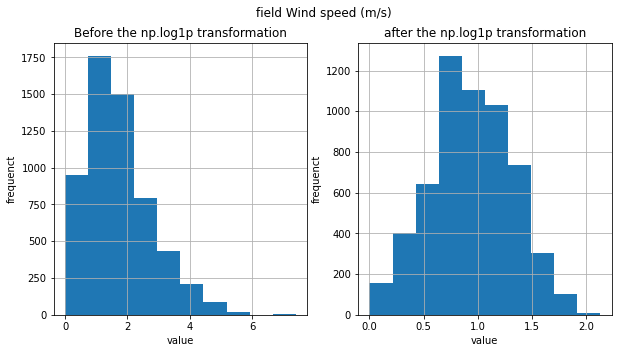

In [18]:


# Let's look at what happens to one of these features when we apply np.log1p visually
field='Wind speed (m/s)'

#Create two subplots and a figure using matplotlib
fig,(ax_before,ax_after)=plt.subplots(1,2,figsize=(10,5))

#Create a histogram of the ax_before subplot
X1[field].hist(ax=ax_before)

#Applying the transformation and create a histogram of the ax_after subplot
X1[field].apply(np.log1p).hist(ax=ax_after)

#Formating the titles for each subplot
ax_before.set(xlabel='value',ylabel='frequenct',title='Before the np.log1p transformation')
ax_after.set(xlabel='value',ylabel='frequenct',title='after the np.log1p transformation')
fig.suptitle('field {}'.format(field));



In [19]:
# #perform the skew transformations

for col in skew_cols.index.values:
    if col=='Seasons_Spring'or col=='Seasons_Summer' or col=='Seasons_Winter' or col=='Visibility (10m)':
        continue
    X1[col]=X1[col].apply(np.log1p)
    

In [20]:
X1.skew().sort_values(ascending=False)

#Skewness has dropped significantly after np.log1p transofrmation

lag_-7_Snowfall (cm)        7.081133
lag_-5_Snowfall (cm)        7.081133
lag_-11_Snowfall (cm)       7.081133
lag_1_Snowfall (cm)         7.081133
lag_3_Snowfall (cm)         7.081133
                              ...   
lag_-7_Visibility (10m)    -2.841555
year                       -3.015899
lag_-9_Visibility (10m)    -3.087709
lag_-11_Visibility (10m)   -3.302125
Functioning Day            -4.513896
Length: 106, dtype: float64

In [21]:
#Now check for Null Values 
print(X1.isnull().sum().sort_values())
X2=X1.copy()


Date                                0
lag_-11_Visibility (10m)            0
lag_-11_Temperature(�C)             0
lag_-11_Hour                        0
lag_-9_weathercluster               0
                                   ..
lag_-1_Dew point temperature(�C)    0
lag_-1_Rainfall(mm)                 0
lag_-1_Snowfall (cm)                0
lag_-3_Snowfall (cm)                0
lag_1_weathercluster                0
Length: 110, dtype: int64


In [22]:
X2_pairplot=pd.concat([X2,pd.DataFrame(y)],axis=1)




In [23]:
X2_pairplot.head()

,Date,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),...,lag_1_Visibility (10m),lag_1_Solar Radiation (MJ/m2),lag_1_y_avg_season_hour,lag_1_Humidity(%),lag_1_Wind speed (m/s),lag_1_Snowfall (cm),lag_1_Rainfall(mm),lag_1_Dew point temperature(�C),lag_1_weathercluster,0
0,2017-01-12,0,-5.2,37,1.163151,2000,-17.6,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,254
1,2017-01-12,1,-5.5,38,0.587787,2000,-17.6,0.0,0.0,0.0,...,7.601402,0.0,5.140786,37.0,1.163151,0.0,0.0,-17.6,13.0,204
2,2017-01-12,2,-6.0,39,0.693147,2000,-17.7,0.0,0.0,0.0,...,7.601402,0.0,5.083576,38.0,0.587787,0.0,0.0,-17.6,5.0,173
3,2017-01-12,3,-6.2,40,0.641854,2000,-17.6,0.0,0.0,0.0,...,7.601402,0.0,4.784013,39.0,0.693147,0.0,0.0,-17.7,5.0,107
4,2017-01-12,4,-6.0,36,1.193922,2000,-18.6,0.0,0.0,0.0,...,7.601402,0.0,4.344238,40.0,0.641854,0.0,0.0,-17.6,5.0,78


In [24]:
ordinal_vals = {'Winter':1,'Spring':2,'Autumn':3,'Summer':4,'No Holiday':0,'Holiday':1}
# ordinal_wof = {25:45,29:44,34:43,42:42,33:41,24:40,28:39,32:38,23:37,49:36,41:35,16:34,45:33,27:32,36:31,20:30,19:29,14:28,46:27,47:26,10:25,2:24,6:23,37:22,15:21,11:20,18:19,1:18,40:17,38:16,9:15,5:14,31:13,12:12,50:11,8:10,22:9,3:8,13:7,35:6,26:5,44:4,7:3,48:2,51:1}

In [25]:
X2 = X2.replace(ordinal_vals)
# X2['SortedWeekOfYear'] = X2['WeekOfYear'].replace(ordinal_wof)

In [26]:
X2['Humidity(%)'] = np.where(X2['Humidity(%)']==0, 57, X2['Humidity(%)'])

In [27]:
X2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5760 entries, 0 to 5759
Columns: 110 entries, Date to lag_1_weathercluster
dtypes: datetime64[ns](2), float64(98), int32(1), int64(9)
memory usage: 4.8 MB


In [28]:
X2.drop(['Date','hours_dt','Dew point temperature(�C)','Snowfall (cm)'], axis=1,inplace=True)

y_log=np.log1p(y)
X_train, X_eval, y_train, y_eval=train_test_split(X2, y_log, test_size=0.3, random_state=42)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4032 entries, 3169 to 860
Columns: 106 entries, Hour to lag_1_weathercluster
dtypes: float64(96), int32(1), int64(9)
memory usage: 3.3 MB


In [29]:
xgb_best = xgboost.XGBRegressor(colsample_bytree= 0.7,
 learning_rate=0.04,
 max_depth= 4,
 min_child_weight= 0.4,
 n_estimators= 2000,
 nthread= 4,
 objective= 'reg:linear',
 silent=1,
 subsample=0.7)
xgb_best.fit(X2,y_log)
pred = xgb_best.predict(X_eval)
print(r2_score(y_eval,pred))
print(np.sqrt(metrics.mean_squared_error(y_eval,pred)))



[14:09:08] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:09:08] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.998112138380374
0.07643771031351976


# Handeling the Test Data

In [30]:
df_test=pd.read_csv('../input/seoul-bike-rental-ai-pro-iti/test.csv')
df_test.head()


,ID,Date,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,5760,21/12/2017,0,-1.3,90,2.0,259,-2.7,0.0,0.0,2.2,Winter,No Holiday,Yes
1,5761,21/12/2017,1,-1.8,90,1.6,263,-3.2,0.0,0.0,2.2,Winter,No Holiday,Yes
2,5762,21/12/2017,2,-2.2,88,1.4,348,-3.9,0.0,0.0,2.2,Winter,No Holiday,Yes
3,5763,21/12/2017,3,-2.9,89,1.3,288,-4.4,0.0,0.0,2.2,Winter,No Holiday,Yes
4,5764,21/12/2017,4,-3.6,91,1.2,241,-4.8,0.0,0.0,2.2,Winter,No Holiday,Yes


In [31]:
df_test['weathercluster'] = model.predict(StandardScaler().fit_transform(df_test[cluster_list]))

In [32]:
merged_test_df=pd.merge(df_test,y_Hour_autumn_df,on=['Seasons','Hour'],how='left')
merged_test_df=pd.merge(merged_test_df,y_Hour_spring_df,on=['Seasons','Hour'],how='left')
merged_test_df=pd.merge(merged_test_df,y_Hour_summer_df,on=['Seasons','Hour'],how='left')
merged_test_df=pd.merge(merged_test_df,y_Hour_winter_df,on=['Seasons','Hour'],how='left')
########################################################
merged_test_df = merged_test_df.fillna(0)
##################################
merged_test_df['y_avg_season_hour'] = merged_test_df['y_avg_autumn_hour']+ merged_test_df['y_avg_spring_hour'] +merged_test_df['y_avg_summer_hour'] +merged_test_df['y_avg_winter_hour']
df_test['y_avg_season_hour'] = merged_test_df['y_avg_season_hour']

In [33]:
X_test=df_test.drop(['ID'], axis=1)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       3000 non-null   object 
 1   Hour                       3000 non-null   int64  
 2   Temperature(�C)            3000 non-null   float64
 3   Humidity(%)                3000 non-null   int64  
 4   Wind speed (m/s)           3000 non-null   float64
 5   Visibility (10m)           3000 non-null   int64  
 6   Dew point temperature(�C)  3000 non-null   float64
 7   Solar Radiation (MJ/m2)    3000 non-null   float64
 8   Rainfall(mm)               3000 non-null   float64
 9   Snowfall (cm)              3000 non-null   float64
 10  Seasons                    3000 non-null   object 
 11  Holiday                    3000 non-null   object 
 12  Functioning Day            3000 non-null   object 
 13  weathercluster             3000 non-null   int32

In [34]:
def lag(data,features, shift):
    for feature in features:
        data['lag_'+str(shift)+'_'+feature] = data[feature].shift(shift)

In [35]:
lag(X_test,features,-1)
lag(X_test,features,-3)
lag(X_test,features,-5)
lag(X_test,features,-7)
lag(X_test,features,-9)
lag(X_test,features,-11)
lag(X_test,features,3)
lag(X_test,features,1)





In [36]:
X1_test=X_test.copy()


X1_test=Binarizer('Functioning Day',X1_test)

In [37]:


#Changing date object to datetime 
X1_test['Date']=pd.to_datetime(X1_test['Date'])


In [38]:
num_cols=X1_test.select_dtypes('number').columns
skew_limit=0.75
skew_vals=X1_test[num_cols].skew()

In [39]:
#Showing the skew columns
skew_cols=skew_vals[abs(skew_vals)>skew_limit].sort_values(ascending=False)
skew_cols

Rainfall(mm)                       12.901337
lag_-1_Rainfall(mm)                12.899179
lag_1_Rainfall(mm)                 12.899179
lag_3_Rainfall(mm)                 12.894861
lag_-3_Rainfall(mm)                12.894861
lag_-5_Rainfall(mm)                12.890541
lag_-7_Rainfall(mm)                12.886220
lag_-9_Rainfall(mm)                12.881898
lag_-11_Rainfall(mm)               12.877574
lag_-11_Snowfall (cm)               7.232700
lag_-9_Snowfall (cm)                7.168659
lag_-7_Snowfall (cm)                7.103499
lag_-5_Snowfall (cm)                7.039614
lag_-3_Snowfall (cm)                6.976967
lag_-1_Snowfall (cm)                6.915523
Snowfall (cm)                       6.885240
lag_1_Snowfall (cm)                 6.884043
lag_3_Snowfall (cm)                 6.881650
Solar Radiation (MJ/m2)             1.540613
lag_1_Solar Radiation (MJ/m2)       1.540123
lag_-1_Solar Radiation (MJ/m2)      1.540123
lag_3_Solar Radiation (MJ/m2)       1.539143
lag_-3_Sol

In [40]:
#perform the skew transformations

for col in skew_cols.index.values:
    if col=='Seasons_Spring'or col=='Seasons_Summer' or col=='Seasons_Winter' or col=='Visibility (10m)':
        continue
    X1_test[col]=X1_test[col].apply(np.log1p)
    

In [41]:
X2_test=X1_test.copy()

In [42]:
# Tranforming Date to days,months and years
X2_test['year']=pd.to_datetime(X2_test['Date'].dt.year)
X2_test['day']=pd.to_datetime(X2_test['Date'].dt.day)

X2_test['year']=pd.to_numeric(X2_test['year'])
X2_test['day']=pd.to_numeric(X2_test['day'])





In [43]:
X2_test['dayofweek'] = X2_test['Date'].dt.dayofweek
X2_test['WeekOfYear'] = X2_test['Date'].dt.isocalendar().week.astype(np.int64)
X2_test['DayofYear'] = X2_test['Date'].dt.dayofyear
X2_test['hours_dt'] = pd.to_datetime(X2_test['Hour'], format='%H')
X2_test['Travelling_time'] = np.where(X2_test['Hour'].isin(hours_list), 1, 0)


X2_test.drop('Date',axis=1,inplace=True)

X2_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Columns: 109 entries, Hour to Travelling_time
dtypes: datetime64[ns](1), float64(96), int32(1), int64(9), object(2)
memory usage: 2.5+ MB


In [44]:
X2_test = X2_test.replace(ordinal_vals)

In [45]:
X2_test['Humidity(%)'] = np.where(X2_test['Humidity(%)']==0, 57, X2_test['Humidity(%)'])

In [46]:
cols_list = X2.columns.tolist()

In [47]:
X2_test=X2_test[cols_list]

X2_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Columns: 106 entries, Hour to lag_1_weathercluster
dtypes: float64(94), int32(1), int64(11)
memory usage: 2.4 MB


In [48]:
X2_test.fillna(0,inplace=True)

In [49]:
y_test_predict_XGB=xgb_best.predict(X2_test)

In [50]:
y_test_final_XGB=np.exp(y_test_predict_XGB)-1
y_test_final_XGB = np.where(y_test_final_XGB<0.0,0,y_test_final_XGB)

In [51]:
df_testXGB=df_test.copy()

In [52]:
df_testXGB['y']=y_test_final_XGB



In [53]:
df_testXGB[['ID','y']].to_csv('/kaggle/working/submissiongbrXGBFinal.csv', index=False)